<a href="https://colab.research.google.com/github/Kritarth-Dandapat/CSE-473-Marine-Guardian/blob/master/Report%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Marine Guardian: Satellite Image Ship Detection
KRITARTH DANDAPAT     UBID: 5052318

Import Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

## 1. Data Loading and Exploration



### 1.1 Load the Dataset

-   Download the dataset from Kaggle and extract it to a local directory.
-   Load the images and their corresponding labels (if available).
-   Explore the dataset to understand its structure and content.

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kritarthdandapat","key":"ed484c1e5683eedcd7cc67ee2d132188"}'}

In [7]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [8]:
import os
import subprocess

dataset_slug = "rhammell/ships-in-satellite-imagery"
destination_path = "./ships_dataset"

# Create destination directory if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

# Path to the zip file
zip_file_path = os.path.join(destination_path, f"{dataset_slug.split('/')[1]}.zip")

# Check if the dataset already exists
if os.path.exists(zip_file_path):
    print(f"Dataset '{dataset_slug}' already exists at '{destination_path}'. Skipping download.")
else:
    try:
        # Download the dataset if not already present
        command = ["kaggle", "datasets", "download", "-d", dataset_slug, "-p", destination_path]
        subprocess.run(command, check=True)
        print(f"Dataset '{dataset_slug}' downloaded successfully to '{destination_path}'.")
    except subprocess.CalledProcessError as e:
        print(f"Error downloading dataset '{dataset_slug}': {e}")
    except FileNotFoundError:
        print("Kaggle API not found. Please ensure the Kaggle CLI is installed and configured.")
        print("You can install it using: pip install kaggle")
        print("And configure it by placing your kaggle.json file in ~/.kaggle/")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

Dataset 'rhammell/ships-in-satellite-imagery' downloaded successfully to './ships_dataset'.


In [9]:
!unzip -q /content/ships_dataset/ships-in-satellite-imagery.zip -d /content/ships_dataset/

### 1.2 Data Visualization

-   Display sample images to visualize the challenges of satellite imagery.
-   Analyze the distribution of ship sizes and orientations.
-   Identify potential sources of noise and variability.

In [ ]:
import os

dataset_path = destination_path + "/shipsnet/shipsnet"

try:
    image_files = os.listdir(dataset_path)

    image_files = [f for f in image_files if f.endswith(('.jpg', '.jpeg', '.png'))]

    if not image_files:
        raise FileNotFoundError(f"No image files found in '{dataset_path}'.")

    ship_count = 1
    no_ship_count = 1

    for old_name in image_files:
        old_path = os.path.join(dataset_path, old_name)
        parts = old_name.split("_")
        label = parts[0]

        if label == "1": # ship
            new_name = f"S {ship_count:05d}.png"
            ship_count += 1
        elif label == "0": # no ship
            new_name = f"NS {no_ship_count:05d}.png"
            no_ship_count += 1
        else:
            print(f"Warning: Invalid label '{label}' in file '{old_name}'. Skipping.")
            continue  # Skip files with invalid labels

        new_path = os.path.join(dataset_path, new_name)
        os.rename(old_path, new_path)
        print(f"Renamed '{old_name}' to '{new_name}'")

    print("All files renamed successfully.")

except FileNotFoundError as e:
    print(e)
except FileExistsError as e:
        print(f"File already exists: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

All files renamed successfully.


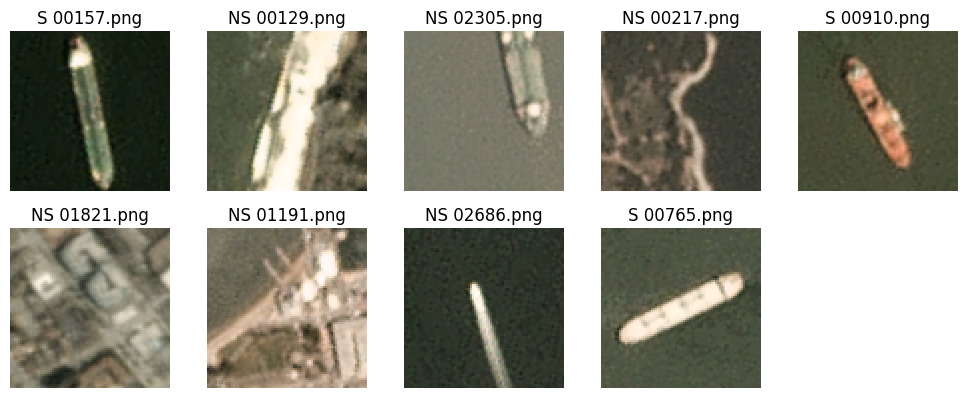

In [ ]:
import random

dataset_path = destination_path + "/shipsnet/shipsnet"

try:
    image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if not image_files:
        raise FileNotFoundError(f"No image files found in '{dataset_path}'.")

    num_images_to_display = min(9, len(image_files))  # Display up to 9 images
    random_images = random.sample(image_files, num_images_to_display)

    plt.figure(figsize=(10, 10))
    for i, image_file in enumerate(random_images):
        image_path = os.path.join(dataset_path, image_file)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

        plt.subplot(5, 5, i + 1)
        plt.imshow(img)
        plt.title(image_file)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
import os
import tensorflow as tf

def create_dataset(path, batch_size=32):
    """Creates a dataset from images in a directory with labels."""

    # Get list of image file paths
    image_files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Assign labels based on filename containing 'ship ' (with space)
    labels = [1 if os.path.basename(f).lower().startswith('s ') else 0 for f in image_files]

    # Convert lists to tensors
    image_files = tf.convert_to_tensor(image_files, dtype=tf.string)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)

    def load_image(image_path, label):
        """Loads an image and returns the image tensor along with its label."""
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)  # Adjust for PNG if necessary
        return image, label  # Ensure label is returned with the image

    # Create dataset with image paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((image_files, labels))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Batch and prefetch for performance
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

# Example usage
dataset_path = '/content/ships_dataset/shipsnet/shipsnet'  # Replace with your dataset path
dataset = create_dataset(dataset_path)

# Check the dataset output
for batch_images, batch_labels in dataset.take(1):
    print("Batch image shape:", batch_images[0].shape)
    print("Batch labels:", batch_labels.numpy())


Batch image shape: (80, 80, 3)
Batch labels: [0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 0 0]


## Basic Data Augementation

In [ ]:
def augment_image(image, label):
    """Applies random augmentations to an image."""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

In [ ]:
augmented_dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

IndexError: index 9 is out of bounds for axis 0 with size 9

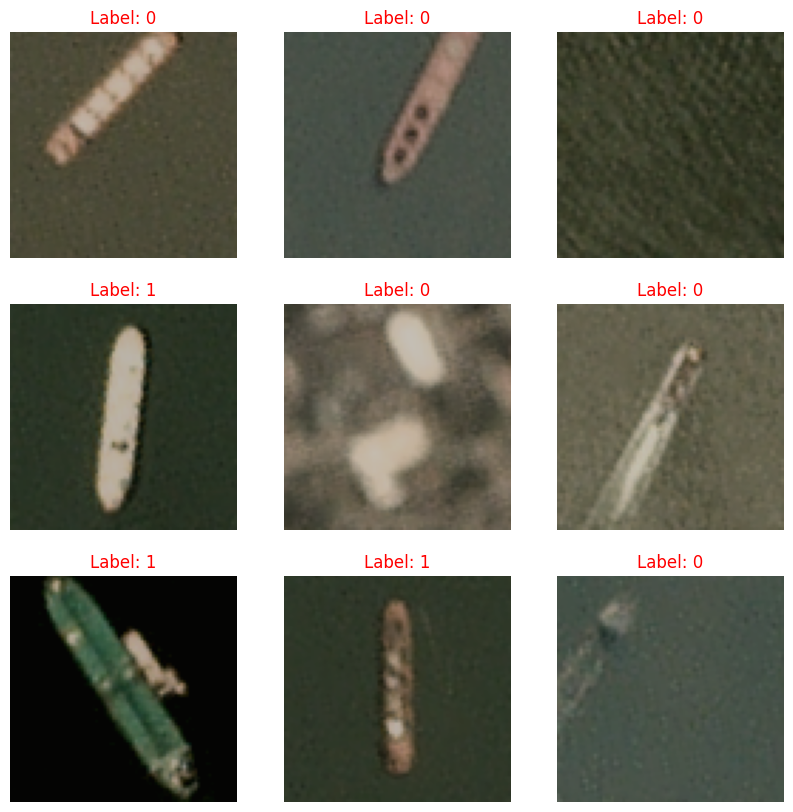

In [ ]:
import matplotlib.pyplot as plt

# Set up the figure with a 4x4 grid
fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # 4x4 grid of subplots
axes = axes.flatten()  # Flatten the axes array for easy indexing

for images, labels in augmented_dataset.take(1):  # Take a single batch
    num_images = min(16, images.shape[0])  # Ensure we don't exceed batch size

    for j in range(num_images):
        image = images[j].numpy()  # Convert to NumPy array
        label = labels[j].numpy()  # Convert label to NumPy

        # If images are normalized, rescale to [0, 255]
        if image.max() <= 1.0:
            image = (image * 255).astype('uint8')

        axes[j].imshow(image)
        axes[j].axis('off')  # Turn off axis
        axes[j].set_title(f"Label: {label}", fontsize=12, color='red')  # Show label

# Remove any unused subplots (in case batch < 16)
for j in range(num_images, 16):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [ ]:
def preprocess_image(image, label, target_size=(224, 224)):
    """Preprocessing function that resizes and normalizes the image tensor."""
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

preprocessed_dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

for batch_images, batch_labels in preprocessed_dataset.take(1):
    print("Preprocessed batch image shape:", batch_images[0].shape)
    print("Preprocessed batch labels:", batch_labels.numpy())

Preprocessed batch image shape: (224, 224, 3)
Preprocessed batch labels: [0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 0 0]


In [ ]:
dataset_size = 125 # this is the number of bacthes orughly 4008/32 is 125
dataset = preprocessed_dataset.shuffle(buffer_size=dataset_size, reshuffle_each_iteration=False)

# Split the dataset into train (70%), validation (15%), and test (15%)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset = dataset.take(train_size)
remaining_dataset = dataset.skip(train_size)

val_dataset = remaining_dataset.take(val_size)
test_dataset = remaining_dataset.skip(val_size)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

train_count = sum(1 for _ in train_dataset)
val_count = sum(1 for _ in val_dataset)
test_count = sum(1 for _ in test_dataset)

# Example: Print sizes of datasets and shapes of batches
print(f"Train dataset size (batches): {train_count}")
print(f"Validation dataset size (batches): {val_count}")
print(f"Test dataset size (batches): {test_count}")

# Print the shape of a sample batch from each dataset
for images, label in train_dataset.take(1):
    print("\n\nTrain batch shape:", images.shape)

for images, label in val_dataset.take(1):
    print("Validation batch shape:", images.shape)

for images, label in test_dataset.take(1):
    print("Test batch shape:", images.shape)


Train dataset size (batches): 87
Validation dataset size (batches): 18
Test dataset size (batches): 20


Train batch shape: (32, 224, 224, 3)
Validation batch shape: (32, 224, 224, 3)
Test batch shape: (32, 224, 224, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models


input_shape = (224, 224, 3)

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),  # Input layer for images
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),  # Flatten to feed into fully connected layers
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer with 1 unit for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Use binary crossentropy for binary classification
              metrics=['accuracy'])

# Print model summary to check layers
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,938,561 (49.36 MB)

 Trainable params: 12,938,561 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset)

Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 158ms/step - accuracy: 0.7789 - loss: 0.5151 - val_accuracy: 0.9149 - val_loss: 0.1982
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.9075 - loss: 0.2337 - val_accuracy: 0.9253 - val_loss: 0.1695
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.9272 - loss: 0.1743 - val_accuracy: 0.9444 - val_loss: 0.1507
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.9479 - loss: 0.1333 - val_accuracy: 0.9514 - val_loss: 0.1157
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.9617 - loss: 0.0976 - val_accuracy: 0.9688 - val_loss: 0.1066


In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9662 - loss: 0.1098
Test accuracy: 96.88%


In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history, test_dataset, model):
    """
    Function to plot training, validation, and test loss and accuracy.

    Args:
    - history: The training history returned by model.fit()
    - test_dataset: The test dataset
    - model: The trained model

    """
    # Evaluate the model on the test dataset
    test_loss, test_accuracy = model.evaluate(test_dataset)

    # Extract loss and accuracy values from training history
    history_dict = history.history

    # Plot Loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)  # Create subplot (1 row, 2 columns, 1st plot)
    plt.plot(history_dict['loss'], label='Training Loss', marker='o')
    plt.plot(history_dict['val_loss'], label='Validation Loss', marker='o')
    plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')  # Horizontal test loss line
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training, Validation & Test Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    if 'accuracy' in history_dict:  # Some models may use 'acc' instead of 'accuracy'
        plt.subplot(1, 2, 2)  # Create subplot (1 row, 2 columns, 2nd plot)
        plt.plot(history_dict['accuracy'], label='Training Accuracy', marker='o')
        plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', marker='o')
        plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')  # Horizontal test accuracy line
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training, Validation & Test Accuracy')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()  # Adjust layout for better appearance
    plt.show()





20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9662 - loss: 0.1098


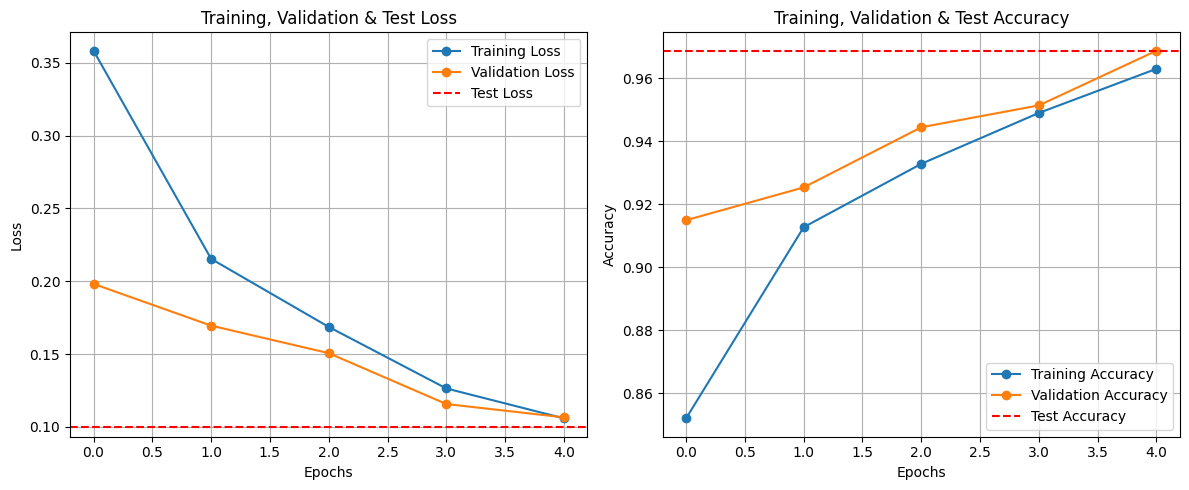

In [ ]:
plot_training_history(history, test_dataset, model)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

# Load EfficientNetB0 with pre-trained weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Build the classification model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,213,797 (16.07 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset)

Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 47s 191ms/step - accuracy: 0.7113 - loss: 0.6234 - val_accuracy: 0.7396 - val_loss: 0.5809
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.7472 - loss: 0.5728 - val_accuracy: 0.7396 - val_loss: 0.5765
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.7472 - loss: 0.5710 - val_accuracy: 0.7396 - val_loss: 0.5780
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.7472 - loss: 0.5735 - val_accuracy: 0.7396 - val_loss: 0.5771
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.7472 - loss: 0.5727 - val_accuracy: 0.7396 - val_loss: 0.5744


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7425 - loss: 0.5717


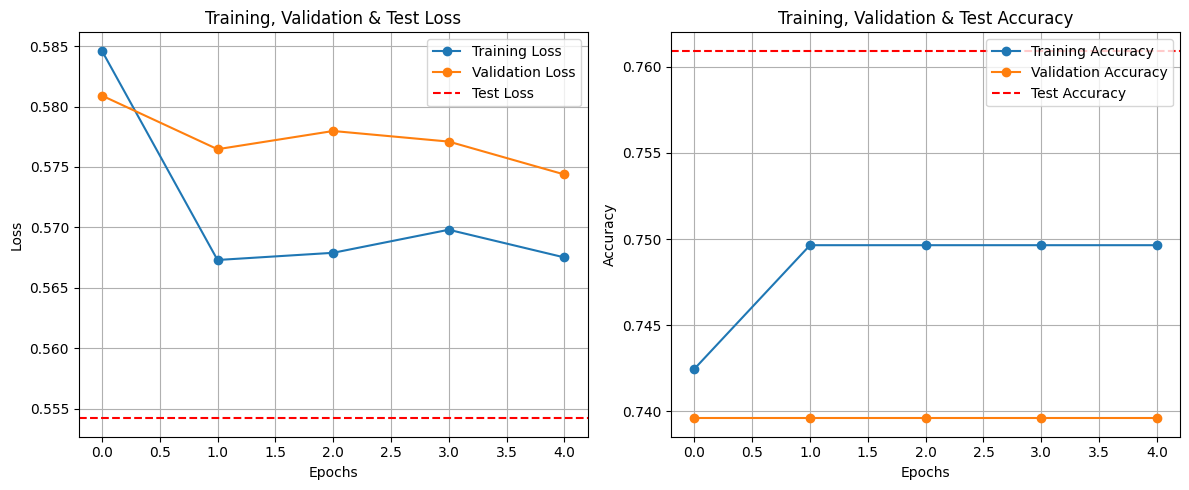

In [ ]:
import matplotlib.pyplot as plt

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

# Extract loss and accuracy values from training history
history_dict = history.history

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # Create subplot (1 row, 2 columns, 1st plot)
plt.plot(history_dict['loss'], label='Training Loss', marker='o')
plt.plot(history_dict['val_loss'], label='Validation Loss', marker='o')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')  # Horizontal test loss line
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation & Test Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
if 'accuracy' in history_dict:  # Some models may use 'acc' instead of 'accuracy'
    plt.subplot(1, 2, 2)  # Create subplot (1 row, 2 columns, 2nd plot)
    plt.plot(history_dict['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')  # Horizontal test accuracy line
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training, Validation & Test Accuracy')
    plt.legend()
    plt.grid(True)

plt.tight_layout()  # Adjust layout for better appearance
plt.show()


In [ ]:
from tensorflow.keras.applications import MobileNetV2

# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze pre-trained weights

# Build the binary classification model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset)

Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - accuracy: 0.8958 - loss: 0.2251 - val_accuracy: 0.9792 - val_loss: 0.0778
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.9754 - loss: 0.0655 - val_accuracy: 0.9844 - val_loss: 0.0509
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.9858 - loss: 0.0387 - val_accuracy: 0.9878 - val_loss: 0.0418
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9926 - loss: 0.0244 - val_accuracy: 0.9913 - val_loss: 0.0286
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - accuracy: 0.9970 - loss: 0.0162 - val_accuracy: 0.9931 - val_loss: 0.0230


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9872 - loss: 0.0472


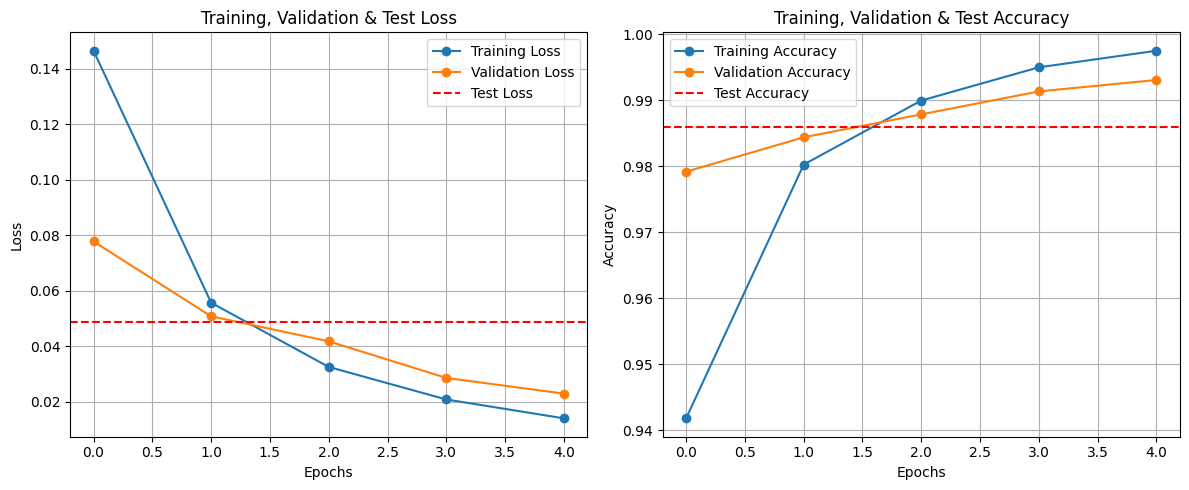

In [ ]:
import matplotlib.pyplot as plt

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

# Extract loss and accuracy values from training history
history_dict = history.history

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # Create subplot (1 row, 2 columns, 1st plot)
plt.plot(history_dict['loss'], label='Training Loss', marker='o')
plt.plot(history_dict['val_loss'], label='Validation Loss', marker='o')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')  # Horizontal test loss line
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation & Test Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
if 'accuracy' in history_dict:  # Some models may use 'acc' instead of 'accuracy'
    plt.subplot(1, 2, 2)  # Create subplot (1 row, 2 columns, 2nd plot)
    plt.plot(history_dict['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')  # Horizontal test accuracy line
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training, Validation & Test Accuracy')
    plt.legend()
    plt.grid(True)

plt.tight_layout()  # Adjust layout for better appearance
plt.show()


The core issue stems from dataset mislabeling and class imbalance, which self-supervised learning (SSL) combined with semi-supervised techniques can address. Below is a TensorFlow implementation using SimCLR (from search result) and pseudo-labeling (from search result) to leverage both labeled and unlabeled data effectively.

In [13]:
!pip install tensorflow_similarity

  Using cached tensorflow_similarity-0.17.1-py3-none-any.whl.metadata (9.5 kB)
  Using cached distinctipy-1.3.4-py3-none-any.whl.metadata (7.7 kB)
  Using cached nmslib-2.1.1.tar.gz (188 kB)
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.6.1-py2.py3-none-any.whl.metadata (8.7 kB)
Using cached tensorflow_similarity-0.17.1-py3-none-any.whl (230 kB)
Using cached distinctipy-1.3.4-py3-none-any.whl (26 kB)
Using cached pybind11-2.6.1-py2.py3-none-any.whl (188 kB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for nmslib
  Running setup.py clean for nmslib
Failed to build nmslib
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (nmslib)


In [20]:
import os
import tensorflow as tf

def create_dataset(path, batch_size=32):
    """Creates a dataset from images in a directory without labels."""

    # Get list of image file paths
    image_files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Convert list to tensor
    image_files = tf.convert_to_tensor(image_files, dtype=tf.string)

    def load_image(image_path):
        """Loads an image and returns the image tensor."""
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)  # Adjust for PNG if necessary
        return image

    # Create dataset with image paths
    dataset = tf.data.Dataset.from_tensor_slices(image_files)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Batch and prefetch for performance
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

# Example usage
dataset_path = '/content/ships_dataset/shipsnet/shipsnet'  # Replace with your dataset path
dataset = create_dataset(dataset_path)

# Check the dataset output
for batch_images in dataset.take(1):
    print("Batch image shape:", batch_images[0].shape)

print("Batch Size: ", len(dataset))

Batch image shape: (80, 80, 3)
Batch Size:  125


In [25]:
!rm -rf /content/cluster_1/

In [27]:
!mkdir /content/cluster_0

In [21]:
import os
import tensorflow as tf
import numpy as np
from glob import glob

def load_images_from_clusters(cluster_path):
    """Loads images from clustered directories."""
    image_files = glob(os.path.join(cluster_path, "*/*.png"))  # Adjust for your image format

    images = []
    for img_path in image_files:
        image = tf.io.read_file(img_path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, (64, 64))  # Resize if necessary
        images.append(image)

    return np.array(images)  # Convert list to NumPy array

# Example usage
cluster_path = "/content/clusters/"  # Replace with actual cluster directory
images = load_images_from_clusters(cluster_path)

In [28]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.models import Model
from glob import glob

def load_images_from_dataset(dataset_path):
    """Loads images from the dataset directory."""
    image_files = glob(os.path.join(dataset_path, "*.png"))  # Adjust for your image format

    images = []
    for img_path in image_files:
        image = tf.io.read_file(img_path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, (64, 64))  # Resize if necessary
        images.append(image)

    return np.array(images)  # Convert list to NumPy array

# Load dataset
dataset_path = '/content/ships_dataset/shipsnet/shipsnet'  # Replace with your dataset path
images = load_images_from_dataset(dataset_path)

# Normalize images
images = images / 255.0

# Define Autoencoder
input_img = Input(shape=(64, 64, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

# Decoder
x = UpSampling2D((2, 2))(encoded)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder
autoencoder.fit(images, images, epochs=20, batch_size=32, shuffle=True)

# Extract feature representations from encoder
encoder = Model(input_img, encoded)
features = encoder.predict(images)

# Flatten features for clustering
features_flat = features.reshape(features.shape[0], -1)

# Step 2: Apply KMeans Clustering
num_clusters = 2  # Since we have "ship" and "no ship"
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features_flat)

# Step 3: Save relabeled data
for i, label in enumerate(cluster_labels):
    cluster_dir = f"cluster_{label}"
    os.makedirs(cluster_dir, exist_ok=True)
    plt.imsave(os.path.join(cluster_dir, f"image_{i}.png"), images[i])


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0196
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0019
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0014
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 9.2978e-04
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 7.6282e-04
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 7.3110e-04
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 6.6866e-04
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 6.9264e-04
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 6.2075e-04
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.3399e-04
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.1172e-04
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.4046e-04
Epoch 13/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.0587e-04
Epoch 14/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 5.2546e-04

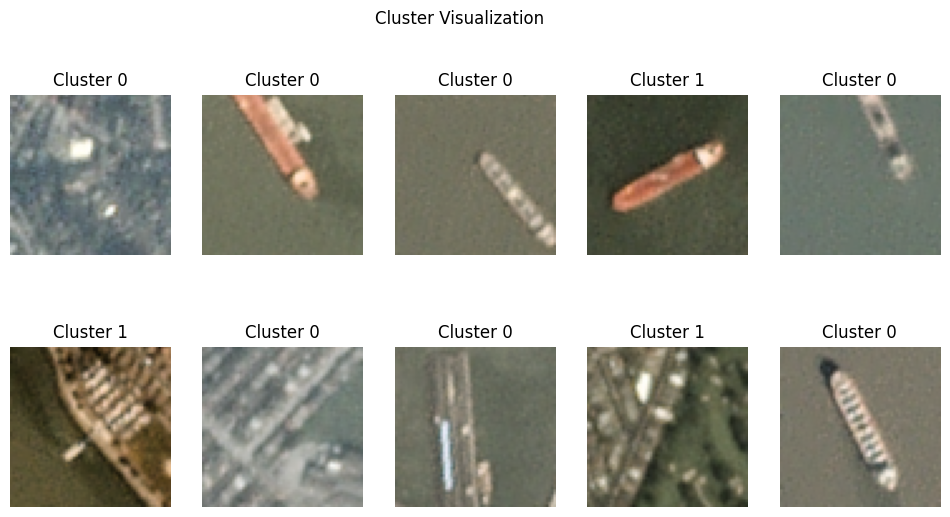

In [30]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle("Cluster Visualization")

for i in range(10):  # Show 10 images from clusters
    ax = axes[i // 5, i % 5]
    ax.imshow(images[i])
    ax.set_title(f"Cluster {cluster_labels[i]}")
    ax.axis("off")

plt.show()


In [31]:
num_ships = np.sum(cluster_labels == 1)
num_no_ships = np.sum(cluster_labels == 0)
print(f"Number of ship images: {num_ships}")
print(f"Number of no-ship images: {num_no_ships}")

Number of ship images: 1599
Number of no-ship images: 2401


In [33]:
!rm -rf /content/cluster_1/

125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step
Number of ship images: 3163
Number of no-ship images: 837


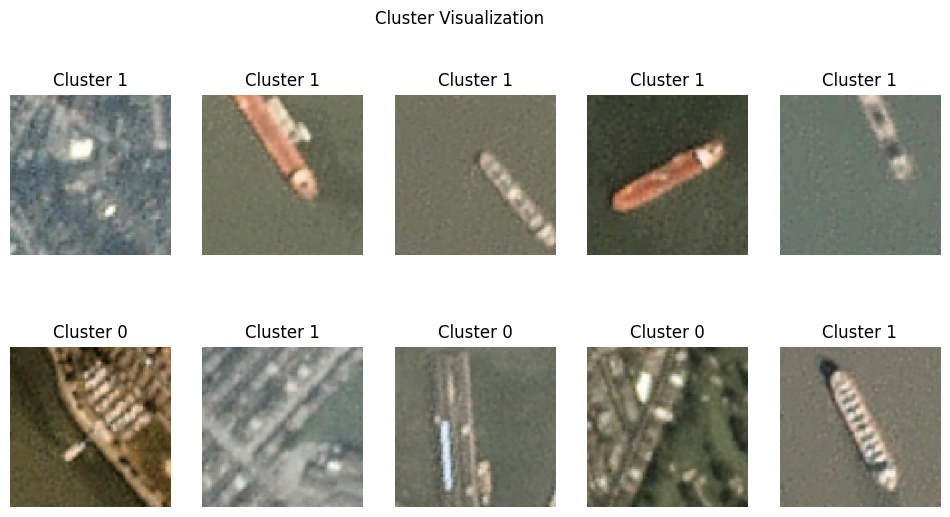

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from glob import glob

def load_images_from_dataset(dataset_path):
    """Loads images from the dataset directory."""
    image_files = glob(os.path.join(dataset_path, "*.png"))  # Adjust for your image format

    images = []
    for img_path in image_files:
        img = image.load_img(img_path, target_size=(224, 224))  # ResNet50 expects 224x224 input
        img_array = image.img_to_array(img)
        images.append(img_array)

    return np.array(images)  # Convert list to NumPy array

# Load dataset
dataset_path = '/content/ships_dataset/shipsnet/shipsnet'  # Replace with your dataset path
images = load_images_from_dataset(dataset_path)

# Normalize images
images = images / 255.0

# Load pre-trained ResNet50 model (without top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

# Extract feature representations
features = model.predict(images)

# Flatten features for clustering
features_flat = features.reshape(features.shape[0], -1)

# Step 2: Apply KMeans Clustering
num_clusters = 2  # Since we have "ship" and "no ship"
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features_flat)

# Count the number of images in each cluster
num_ships = np.sum(cluster_labels == 1)
num_no_ships = np.sum(cluster_labels == 0)
print(f"Number of ship images: {num_ships}")
print(f"Number of no-ship images: {num_no_ships}")

# Step 3: Save relabeled data
for i, label in enumerate(cluster_labels):
    cluster_dir = f"cluster_{label}"
    os.makedirs(cluster_dir, exist_ok=True)
    plt.imsave(os.path.join(cluster_dir, f"image_{i}.png"), images[i])

# Step 4: Visualize clusters
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle("Cluster Visualization")

for i in range(10):  # Show 10 images from clusters
    ax = axes[i // 5, i % 5]
    ax.imshow(images[i])
    ax.set_title(f"Cluster {cluster_labels[i]}")
    ax.axis("off")

plt.show()


In [6]:
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to load images from a folder
def load_images_from_folder(folder_path, label):
    """Loads images from a given folder and assigns a label."""
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]
    images = []
    for img_path in image_files:
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, (64, 64))  # Resize if necessary
        images.append((img, label))
    return images

# Load images from both clusters
cluster_0_images = load_images_from_folder('cluster_0', label=0)  # No ship
cluster_1_images = load_images_from_folder('cluster_1', label=1)  # Ship

# Combine both sets of images
all_images = cluster_0_images + cluster_1_images


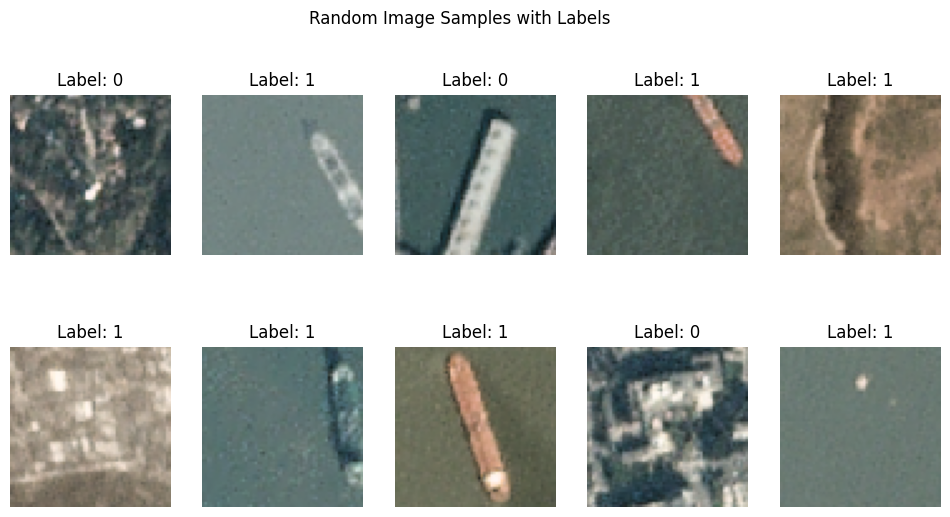

In [8]:
# Randomly select 10 images
random_images = random.sample(all_images, 10)

# Plot the random images with their labels
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle("Random Image Samples with Labels")

for i, (img, label) in enumerate(random_images):
    ax = axes[i // 5, i % 5]
    # Convert the image to a format suitable for imshow (uint8 for integer images)
    img = tf.cast(img, tf.uint8)  # Ensure image is in uint8 format
    ax.imshow(img)
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.show()

### Finally accuracy of the model has been improved

In [ ]:
import os
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Function to load and preprocess images
def load_and_preprocess_images(folder_path, label):
    """Load and preprocess images (resize and grayscale)"""
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]
    images = []
    labels = []
    for img_path in image_files:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (64, 64))  # Resize to a fixed size
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        images.append(gray)
        labels.append(label)
    return images, labels

# Function to extract HOG features
def extract_hog_features(images):
    """Extract HOG features from images."""
    hog = cv2.HOGDescriptor()
    hog_features = []
    for image in images:
        features = hog.compute(image)
        hog_features.append(features.flatten())  # Flatten the features
    return np.array(hog_features)

# Load images and labels
cluster_0_images, cluster_0_labels = load_and_preprocess_images('cluster_0', label=0)  # No ship
cluster_1_images, cluster_1_labels = load_and_preprocess_images('cluster_1', label=1)  # Ship

# Combine all images and labels
all_images = cluster_0_images + cluster_1_images
all_labels = cluster_0_labels + cluster_1_labels

# Extract HOG features from images
hog_features = extract_hog_features(all_images)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(hog_features, all_labels, test_size=0.2, random_state=42)

# Initialize the SVM classifier
svm_classifier = SVC(kernel='linear')

# Train the classifier
svm_classifier.fit(X_train, y_train)

# Make predictions
y_pred = svm_classifier.predict(X_test)

# Print classification results
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Visualize a few random predictions
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_test[i].reshape(64, 64), cmap='gray')  # Display the image
    ax.set_title(f"Pred: {y_pred[i]}")
    ax.axis('off')
plt.show()
